### TP0: Introduccion al Analisis de Datos

**Ejecutar inicialmente el siguiente codigo**


In [1]:
from src.catching import attempt_catch
from src.pokemon import PokemonFactory, StatusEffect
import json
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

factory = PokemonFactory("pokemon.json")

with open("pokemon.json", "r") as c:
    pokemons = json.load(c)
    pokemon_names = pokemons.keys()

with open("pokeballs.json", "r") as c:
    pokeballs = json.load(c)

def create_pokemon_pokeball_matrix(tries, level = 100, status_effect = StatusEffect.NONE, health_points = 1):
    pokemon_pokeball_matrix = {} 

    for name in pokemon_names:
        pokemon_pokeball_matrix[name] = {}
        pokemon = factory.create(name, level, status_effect, health_points)
        for ball in pokeballs:
            pokemon_pokeball_matrix[name][ball] = 0
            for _ in range(tries):
                pokemon_pokeball_matrix[name][ball] += attempt_catch(pokemon, ball)[0]
    return pokemon_pokeball_matrix

def create_pokemon_status_matrix(tries, level = 100, ball = 'pokeball', health_points = 1, names = pokemon_names):
    pokemon_status_matrix = {} 

    for name in names: 
        pokemon_status_matrix[name] = {}
        for status_effect in StatusEffect:
            pokemon = factory.create(name, level, status_effect, health_points)
            pokemon_status_matrix[name][status_effect] = 0
            for _ in range(tries):
                pokemon_status_matrix[name][status_effect] += attempt_catch(pokemon, ball)[0]
    return pokemon_status_matrix
    
def create_pokemon_health_matrix(tries, level = 100, ball = 'pokeball', status_effect = StatusEffect.NONE, names = pokemon_names):
    pokemon_status_matrix = {} 

    for name in names:
        pokemon_status_matrix[name] = {}
        for health in [x / 100.0 for x in range(1, 100)]:
            pokemon = factory.create(name, level, status_effect, health)
            pokemon_status_matrix[name][health] = 0
            for _ in range(tries):
                pokemon_status_matrix[name][health] += attempt_catch(pokemon, ball)[0]
    return pokemon_status_matrix

def create_pokemon_level_matrix(tries, ball = 'pokeball', status_effect = StatusEffect.NONE, names = pokemon_names, health_points = 1):
    pokemon_status_matrix = {} 

    for name in names:
        pokemon_status_matrix[name] = {}
        for level in range(1, 100):
            pokemon = factory.create(name, level, status_effect, health_points)
            pokemon_status_matrix[name][level] = 0
            for _ in range(tries):
                pokemon_status_matrix[name][level] += attempt_catch(pokemon, ball)[0]
    return pokemon_status_matrix

### Ejercicio 1: Acerca de las pokebolas
**Ejecutando la funcion 100 veces, para cada Pokemon en condiciones ideales (HP:100 %, LVL 100) ¿Cual es la probabilidad de captura promedio para cada pokebola?**

In [4]:
#TODO: Move to another file?
TRIES = 100

pokeball_stats = {}
pokemon_pokeball_matrix = create_pokemon_pokeball_matrix(tries=TRIES)
df = pd.DataFrame(pokemon_pokeball_matrix).transpose()

for ball in pokeballs:
    pokeball_stats[ball] = f"{df[ball].sum() / len(pokemon_names):.2f}%"

catch_rate_df = pd.DataFrame(pokeball_stats, index=["Catch Rate"])
catch_rate_df

,pokeball,ultraball,fastball,heavyball
Catch Rate,9.20%,19.80%,12.40%,9.80%


En la tabla de arriba se pueden observar las probabilidades de captura promedio de cada pokebola ejecutando 100 veces la funcion para cada pokemon.

<Axes: title={'center': 'Catch rate of pokeballs'}, xlabel='Pokeball'>

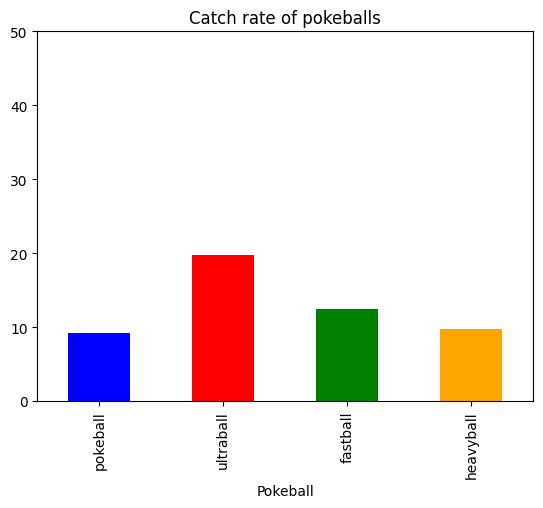

In [5]:
cdft = catch_rate_df.applymap(lambda x: float(x[:-1])).transpose()
cdft.reset_index(inplace=True)
cdft.columns = ["Pokeball", "Catch Rate"]

cdft.plot.bar(
    x="Pokeball",
    y="Catch Rate",
    ylim=(0, 50),
    title="Catch rate of pokeballs",
    legend=False,
    color=['blue', 'red', 'green', 'orange'],
)

Se puede observar en el grafico que la pokeball y la heavyball tienen un promedio de captura similar mienteras que la ultraball tiene mas del doble que ellas. Esto podria deberse a que el unico pokemon pesado que se tiene en la muestra es Snorlax.

**¿Es cierto que algunas pokebolas son mas o menos efectivas dependiendo de propiedades intrinsecas de cada Pokemon?**

In [7]:
TRIES = 1000

pokemon_pokeball_matrix = create_pokemon_pokeball_matrix(tries=TRIES)


df = pd.DataFrame(pokemon_pokeball_matrix)
original_df = df.copy()
df = df.applymap(lambda x: x / TRIES)
jolteon_stats_df = df["jolteon"].copy().map(lambda x: x/df["jolteon"]["pokeball"]).to_frame()
jolteon_stats_df

,jolteon
pokeball,1.000000
ultraball,2.129630
fastball,4.277778
heavyball,0.537037


In [8]:
snorlax_stats_df = df["snorlax"].copy().map(lambda x: x/df["snorlax"]["pokeball"]).to_frame()
snorlax_stats_df

,snorlax
pokeball,1.000000
ultraball,2.085714
fastball,0.857143
heavyball,2.857143


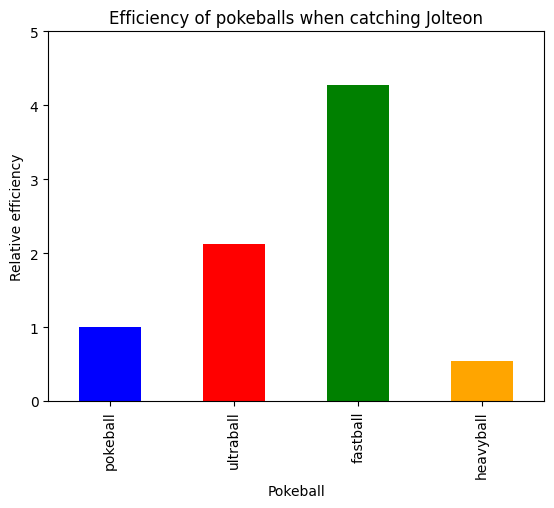

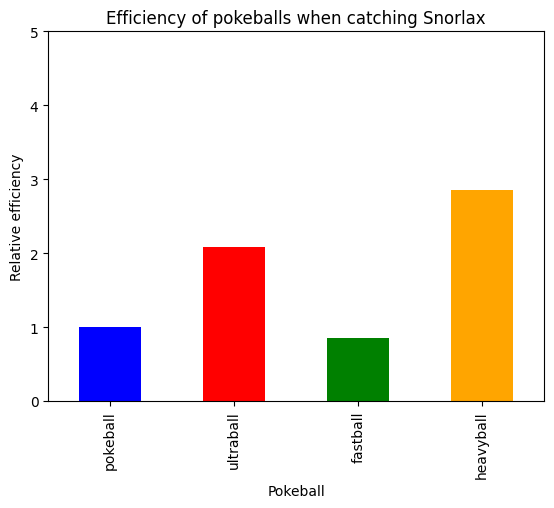

In [9]:
jolteon_stats_df.reset_index(inplace=True)
jolteon_stats_df.columns = ["Pokeball", "Efficiency"]
jolteon_stats_df.plot.bar(x="Pokeball", y="Efficiency", 
                          ylim=(0, 5),
                          title="Efficiency of pokeballs when catching Jolteon",
                          ylabel="Relative efficiency",
                          color=['blue', 'red', 'green', 'orange'],
                          legend=False)

snorlax_stats_df.reset_index(inplace=True)
snorlax_stats_df.columns = ["Pokeball", "Efficiency"]
snorlax_stats_df.plot.bar(x="Pokeball", y="Efficiency", 
                          ylim=(0, 5),
                          title="Efficiency of pokeballs when catching Snorlax",
                          ylabel="Relative efficiency",
                          color=['blue', 'red', 'green', 'orange'],
                          legend=False)
plt.show()

Se puede observar que algunas pokebolas son mas o menos efectivas dependiendo de las propiedades de cada pokemon. 

Usando como referencia la pokebola (efectividad = 1) podemos concluir que la heavyball tiene una efectividad muy baja en Jolteon mientras que en Snorlax tiene una efectividad ampliamente superior al resto. Esto puede deberse a que Jolteon es liviano mientras que Snorlax es lo contrario.

En la fastball se puede concluir un comportamiento inverso a la heavyball, siendo mas efectiva en los pokemones mas livianos y baja en los pesados.

En la ultraball no se detectan variaciones significantes en la efectividad.

### Ejercicio 2: Acerca del estado del Pokemon

**¿Las condiciones de salud tienen algun efecto sobre la efectividad de la captura? Si es asi, ¿Cual es mas o menos efectiva?**


<Axes: title={'center': 'Average and standard deviation of status effects'}>

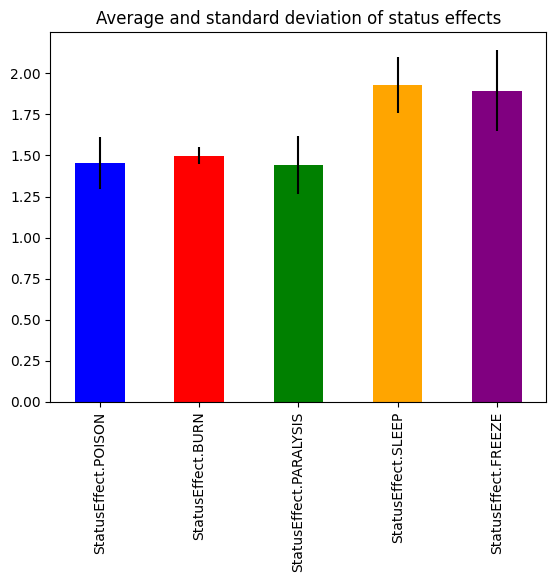

In [14]:
TRIES = 10_000

pokemon_status_matrix = create_pokemon_status_matrix(tries=TRIES)

df = pd.DataFrame(pokemon_status_matrix)
odf = df.copy()

df = df.apply(lambda x: x / x[-1])

status_effect_stats = df.mean(axis=1).to_frame()
status_effect_stats.columns = ["Average"]
status_effect_stats["Standard Deviation"] = df.std(axis=1)
status_effect_stats = status_effect_stats[:-1]
status_effect_stats.plot.bar(y="Average", 
                            yerr="Standard Deviation",
                            title="Average and standard deviation of status effects",
                            color=['blue', 'red', 'green', 'orange', 'purple'],
                            legend=False)

Es verdadero que las condiciones de salud tienen efecto sobre la efectividad de captura.

Se logra observar (teniendo en cuenta el desvio estandar) que los estados de SLEEP y FREEZE tienen un impacto (positivo) en la efectividad superior al resto y casi identico entre ellos.

Las otras tres en menor medida, tambien afectan la efectividad de captura positivamente.

**¿Como afectan los puntos de vida a la efectividad de la captura?**

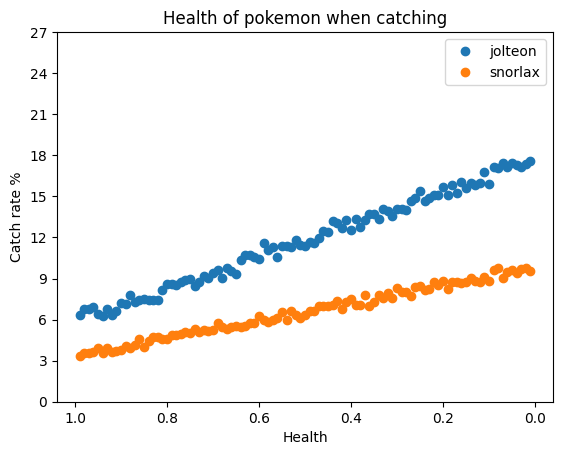

In [17]:
TRIES = 10_000

pokemon_health_matrix = create_pokemon_health_matrix(tries=TRIES, names=["jolteon", "snorlax"])

df = pd.DataFrame(pokemon_health_matrix)
df = df.apply(lambda x: 100 * x / TRIES)

df.plot(title="Health of pokemon when catching",
        yticks=[i for i in range(0, 30, 3)],  # Set y-axis ticks from 0 to 100 by 10
        ylabel="Catch rate %",
        xlabel="Health",
        style=['o', 'o'],
        legend=["Jolteon", "Snorlax"])

plt.gca().invert_xaxis()

plt.show()

Los puntos de vida parecen estar relacionados linealmente con la tasa de captura. Al disminuir la vida del pokemon aumenta la tasa de captura.

El grafico mantiene constante todos los parametros en condicion ideal (nivel maximo, sin status effect y pokeball) salvo por la vida.

Notar que la diferencia entre ambos pokemones se debe a propiedades intrinsecas de cada uno de ellos.

**¿Que parametros son los que mas afectan la probabilidad de captura?**

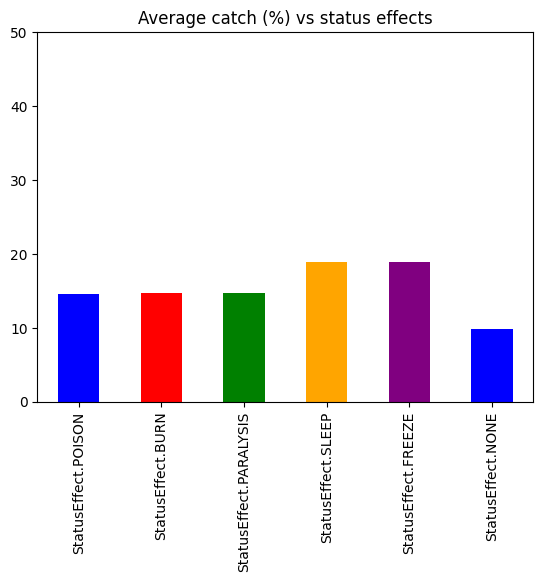

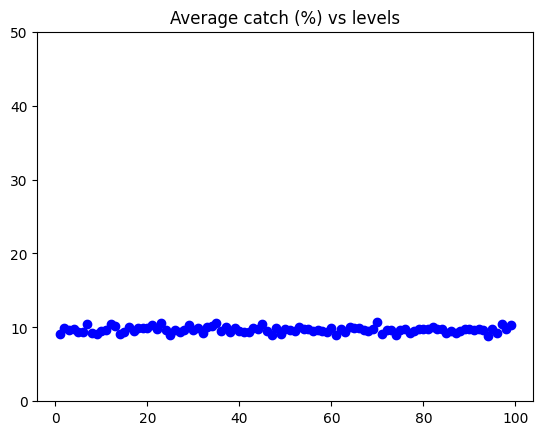

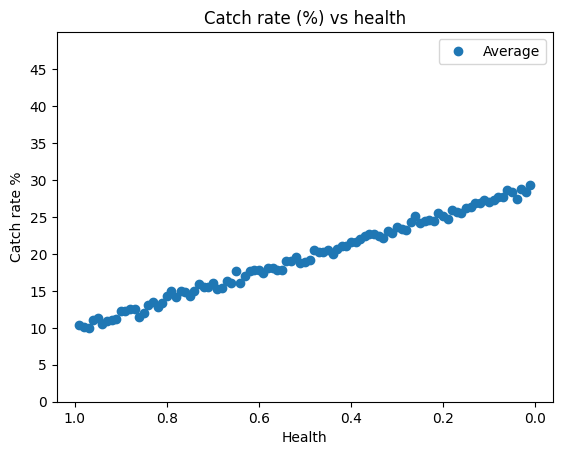

In [28]:
TRIES = 1000

pokemon_status_matrix = create_pokemon_status_matrix(tries=TRIES)

df = pd.DataFrame(pokemon_status_matrix)
df = df.apply(lambda x: 100 * x / TRIES)

mf = df.mean(axis=1).to_frame()
mf.columns = ["Average"]

mf.plot.bar(y="Average", 
            ylim=(0, 50),
            title="Average catch (%) vs status effects",
            color=['blue', 'red', 'green', 'orange', 'purple'],
            legend=False)

pokemon_level_matrix = create_pokemon_level_matrix(tries=TRIES)

df = pd.DataFrame(pokemon_level_matrix)
df = df.apply(lambda x: 100 * x / TRIES)

mf = df.mean(axis=1).to_frame()
mf.columns = ["Average"]

mf.plot(y="Average", 
            ylim=(0, 50),
            title="Average catch (%) vs levels",
            color=['blue', 'red', 'green', 'orange', 'purple'],
            style=['o'],
            legend=False)


pokemon_health_matrix = create_pokemon_health_matrix(tries=TRIES)

df = pd.DataFrame(pokemon_health_matrix)
df = df.apply(lambda x: 100 * x / TRIES)
df = df.mean(axis=1).to_frame()
df.columns = ["Average"]

df.plot(title="Catch rate (%) vs health",
        yticks=[i for i in range(0, 50, 5)],  # Set y-axis ticks from 0 to 100 by 10
        ylabel="Catch rate %",
        ylim=(0, 50),
        xlabel="Health",
        style=['o'])

plt.gca().invert_xaxis()


plt.show()

De los cuatro parametros se puede analizar lo siguiente:

1. Pokeball:
Utilizando el grafico del ejercicio 1a se puede observar que el maximo efecto de la pokeball es de 10% a 20%, es decir el doble.

2. Status Effect:
El estado del pokemon siempre afecta (En comparacion a NONE). Al igual que la pokeball el maximo efecto es el doble de tasa de captura de referencia.

3. Level:
Como se observa en el grafico, el nivel no afecta la tasa de captura (es constante)

4. Health:
La vida como se puede observar siempre afecta el porcentaje de captura. De hecho el maximo efecto (entre 1 y 0) es casi el triple.

Se puede concluir que la vida es el parametro que mas afecta la captura de un pokemon.

**Teniendo en cuenta uno o dos pokemones distintos: ¿Que combinacion de condiciones (propiedades mutables) y pokebola conviene utilizar para capturarlos?**

In [40]:
TRIES = 10_000

jolteon_matrix = create_pokemon_status_matrix(tries=TRIES, names=['jolteon'], health_points=0.5, ball='fastball')
df_jolteon = pd.DataFrame([jolteon_matrix['jolteon']]).apply(lambda x: 100 * x / TRIES).transpose()
df_jolteon.columns = ["Catch rate"]
df_jolteon

,Catch rate
StatusEffect.POISON,71.40
StatusEffect.BURN,69.75
StatusEffect.PARALYSIS,70.82
StatusEffect.SLEEP,94.13
StatusEffect.FREEZE,94.27
StatusEffect.NONE,47.05


Como se observa en el grafco de 1b la pokeball mas efectiva para Jolteon es la fastball.
Utilizando 0.5 de vida (algo realista dentro del juego) se genera la tabla para analizar que status es mas efectivo para Jolteon.

Se recomienda usar (para maximizar la tasa de captura) SLEEP o FREEZE. De todas maneras en caso de no tener uno de ellos, hacer uso de algun otro tambien es fuertemente recomendado.

In [41]:
TRIES = 10_000

snorlax_matrix = create_pokemon_status_matrix(tries=TRIES, names=['snorlax'], health_points=0.5, ball='heavyball')
df_snorlax = pd.DataFrame([snorlax_matrix['snorlax']]).apply(lambda x: 100 * x / TRIES).transpose()
df_snorlax.columns = ["Catch rate"]
df_snorlax

,Catch rate
StatusEffect.POISON,25.05
StatusEffect.BURN,25.41
StatusEffect.PARALYSIS,25.84
StatusEffect.SLEEP,33.59
StatusEffect.FREEZE,33.38
StatusEffect.NONE,16.35


Como se observa en el grafco de 1b la pokeball mas efectiva para Snorlax es la heavyball.
Utilizando 0.5 de vida al igual que el anterior se genera la tabla.

Al igual que con Jolteon se recomienda usar (para maximizar la tasa de captura) SLEEP o FREEZE. De todas maneras en caso de no tener uno de ellos, hacer uso de algun otro tambien es fuertemente recomendado.

Observar que Snorlax es mas dificil de capturar que Jolteon.



**A partir del punto anterior, ¿seria efectiva otra combinacion de parametros teniendo en cuenta un nivel del pokemon mas bajo (o mas alto)?**

In [43]:
TRIES = 10_000

jolteon_matrix = create_pokemon_level_matrix(tries=TRIES, names=['jolteon'], health_points=0.5, ball='fastball', status_effect=StatusEffect.SLEEP)
df_jolteon = pd.DataFrame([jolteon_matrix['jolteon']]).apply(lambda x: 100 * x / TRIES).transpose()
df_jolteon.columns = ["Catch rate"]
df_jolteon.std()

Catch rate    0.756478
dtype: float64

Notar que para Jolteon el desvio estandar de la tasa de captura en relacion al nivel es casi insignificante (0.75%)

In [44]:
TRIES = 10_000

snorlax_matrix = create_pokemon_level_matrix(tries=TRIES, names=['snorlax'], health_points=0.5, ball='heavyball', status_effect=StatusEffect.SLEEP)
df_snorlax = pd.DataFrame([snorlax_matrix['snorlax']]).apply(lambda x: 100 * x / TRIES).transpose()
df_snorlax.columns = ["Catch rate"]
df_snorlax.std()

Catch rate    0.601115
dtype: float64

Notar que para Snorlax el desvio estandar de la tasa de captura en relacion al nivel es casi insignificante (0.75%)

Por lo tanto parece indicar que a pesar del nivel, la tasa de captura es la misma. Se puede atribuir el desvio estandar a la aleatoridad de las capturas.